Label imblance

使用的設備: cuda


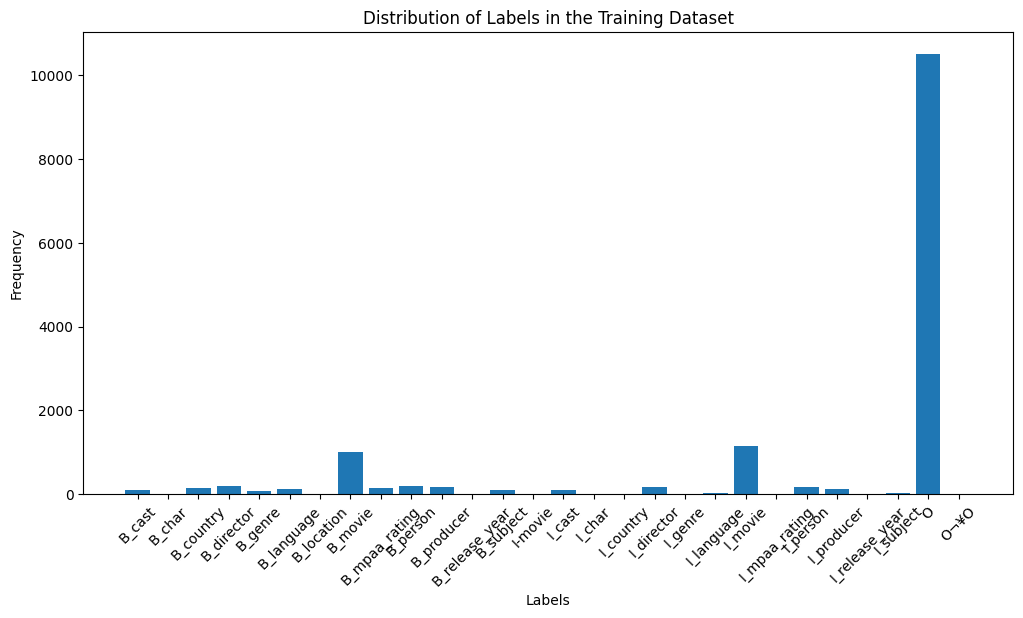

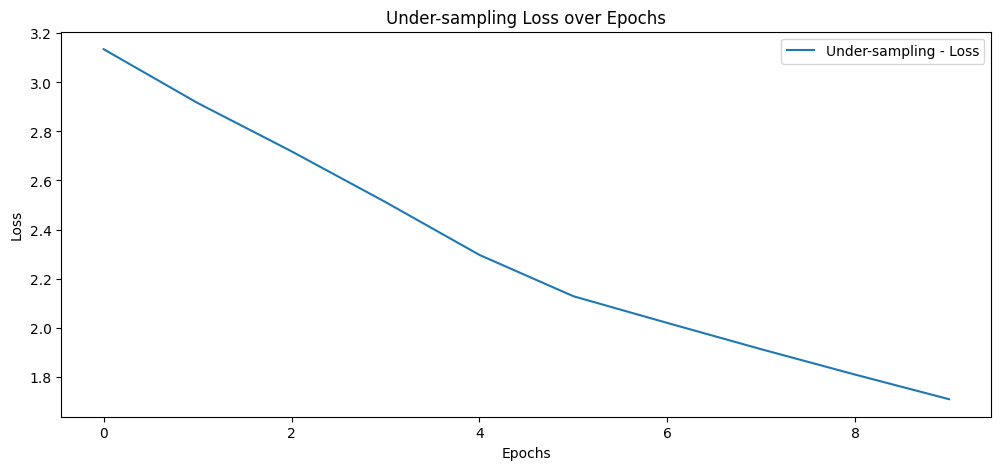

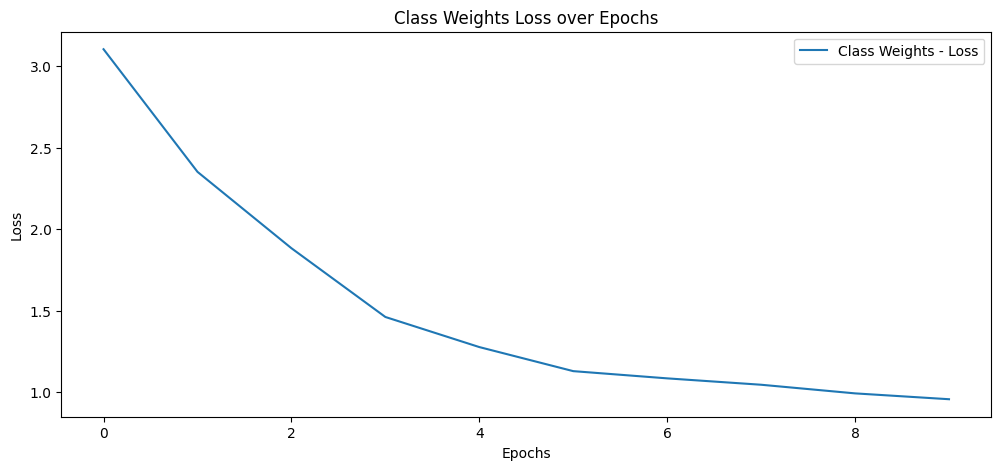

In [11]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
import warnings
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR



warnings.filterwarnings("ignore")

# 檢查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用的設備:", device)

# 加載數據
train_df = pd.read_csv('hw2_train.csv')

# 初始化 BERT Tokenizer 和 Model
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
bert_model = BertModel.from_pretrained("bert-large-uncased").to(device)

# 設定最大序列長度
MAX_LENGTH = 32

# 調整 BERT 編碼函數
def encode_texts(texts, tokenizer, bert_model, device, max_length=MAX_LENGTH):
    inputs = tokenizer(
        texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state  # Shape: (batch_size, max_length, hidden_dim)
    return embeddings, inputs["attention_mask"].sum(dim=1)

# 提取句子的 BERT 嵌入
utterances = train_df['utterances'].tolist()
embeddings, sequence_lengths = encode_texts(utterances, tokenizer, bert_model, device)

# 構建標籤映射字典
unique_labels = set(label for tags in train_df['IOB Slot tags'] for label in tags.split())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_index.items()}

# 計算每個標籤的出現次數並可視化
all_labels = [label for tags in train_df['IOB Slot tags'] for label in tags.split()]
unique_labels, label_counts = np.unique(all_labels, return_counts=True)

plt.figure(figsize=(12, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in the Training Dataset")
plt.xticks(rotation=45)
plt.show()

# 將標籤轉換為數字格式並填充到 BERT 輸出的 max_length 長度
labels = train_df['IOB Slot tags'].apply(lambda x: [label_to_index[label] for label in x.split()])
labels_padded = pad_sequence(
    [torch.tensor(label + [label_to_index["O"]] * (MAX_LENGTH - len(label))) for label in labels], 
    batch_first=True
).to(device)

# 確認嵌入與標籤的形狀一致
assert embeddings.shape[1] == labels_padded.shape[1], "BERT 輸出序列長度和標籤序列長度不匹配"

# 定義使用 GRU 的模型
class SlotTaggingModelGRU(nn.Module):
    def __init__(self, bert_hidden_dim, hidden_dim=91, output_dim=None, dropout_prob=0.24224302298896844, num_layers=2):
        super(SlotTaggingModelGRU, self).__init__()
        self.gru = nn.GRU(
            bert_hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_prob
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        gru_out = self.layer_norm(gru_out)
        gru_out = self.dropout(gru_out)
        
        # 注意力機制
        attn_weights = torch.softmax(self.attention(gru_out), dim=1)
        gru_out = gru_out * attn_weights
        output = self.fc(gru_out)
        return output

# 定義損失和訓練函數
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x).view(-1, output_dim)
        batch_y = batch_y.view(-1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# 訓練和繪製 Loss 圖
def evaluate_and_plot(epochs, train_loader, criterion, model_name):
    model = SlotTaggingModelGRU(bert_hidden_dim, hidden_dim=91, output_dim=output_dim, dropout_prob=0.24224302298896844, num_layers=2).to(device)
    optimizer = AdamW(model.parameters(), lr=0.0008037087742113169, weight_decay=1e-5)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    
    train_losses = []
    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        scheduler.step()
        
    plt.figure(figsize=(12, 5))
    plt.plot(range(epochs), train_losses, label=f'{model_name} - Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss over Epochs")
    plt.legend()
    plt.show()

# 模型參數設置
bert_hidden_dim = embeddings.shape[2]
output_dim = len(label_to_index)
num_epochs = 10  # 測試用短期訓練

# 1. Under-sampling
label_groups = train_df.groupby('IOB Slot tags')
min_samples = label_groups.size().min()
undersampled_data = label_groups.apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

# 重新處理 BERT 輸入和標籤
undersampled_embeddings, _ = encode_texts(undersampled_data['utterances'].tolist(), tokenizer, bert_model, device)
undersampled_labels = undersampled_data['IOB Slot tags'].apply(lambda x: [label_to_index[label] for label in x.split()])
undersampled_labels_padded = pad_sequence(
    [torch.tensor(label + [label_to_index["O"]] * (MAX_LENGTH - len(label))) for label in undersampled_labels], 
    batch_first=True
).to(device)

train_loader_undersample = DataLoader(TensorDataset(undersampled_embeddings, undersampled_labels_padded), batch_size=32, shuffle=True)
criterion = nn.CrossEntropyLoss()  # 不適用 class weights
evaluate_and_plot(num_epochs, train_loader=train_loader_undersample, criterion=criterion, model_name="Under-sampling")

# 2. Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights_dict = {label_to_index[label]: weight for label, weight in zip(np.unique(all_labels), class_weights)}
class_weights_tensor = torch.tensor([class_weights_dict[i] for i in range(len(label_to_index))], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
train_loader_weights = DataLoader(TensorDataset(embeddings, labels_padded), batch_size=32, shuffle=True)
evaluate_and_plot(num_epochs, train_loader=train_loader_weights, criterion=criterion, model_name="Class Weights")



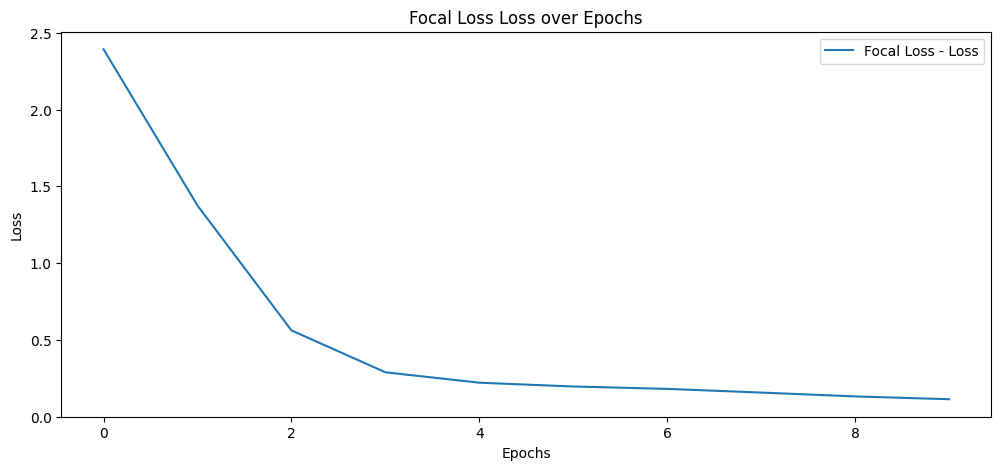

In [12]:
# 定義 Focal Loss 類
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)  # 計算正確樣本的概率
        focal_loss = self.alpha * ((1 - p_t) ** self.gamma) * ce_loss
        return focal_loss.mean()
# 3. Focal Loss
criterion = FocalLoss(alpha=1, gamma=2)
train_loader_focal = DataLoader(TensorDataset(embeddings, labels_padded), batch_size=32, shuffle=True)
evaluate_and_plot(num_epochs, train_loader=train_loader_focal, criterion=criterion, model_name="Focal Loss")

OPTUNA

In [13]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import warnings
import optuna
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings("ignore")

# 檢查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 加載數據
train_df = pd.read_csv('hw2_train.csv')

# 初始化 BERT Tokenizer 和 Model
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
bert_model = BertModel.from_pretrained("bert-large-uncased").to(device)

# 設定最大序列長度
MAX_LENGTH = 32

# 調整 BERT 編碼函數
def encode_texts(texts, tokenizer, bert_model, device, max_length=MAX_LENGTH):
    inputs = tokenizer(
        texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state  # Shape: (batch_size, max_length, hidden_dim)
    return embeddings, inputs["attention_mask"].sum(dim=1)

# 提取句子的 BERT 嵌入
utterances = train_df['utterances'].tolist()
embeddings, sequence_lengths = encode_texts(utterances, tokenizer, bert_model, device)

# 構建標籤映射字典
unique_labels = set(label for tags in train_df['IOB Slot tags'] for label in tags.split())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_index.items()}

# 將標籤轉換為數字格式並填充到 BERT 輸出的 max_length 長度
labels = train_df['IOB Slot tags'].apply(lambda x: [label_to_index[label] for label in x.split()])
labels_padded = pad_sequence(
    [torch.tensor(label + [label_to_index["O"]] * (MAX_LENGTH - len(label))) for label in labels], 
    batch_first=True
).to(device)

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels_padded, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

# 定義 Focal Loss 類
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - p_t) ** self.gamma) * ce_loss
        return focal_loss.mean()

# 定義使用 GRU 的模型
class SlotTaggingModelGRU(nn.Module):
    def __init__(self, bert_hidden_dim, hidden_dim, output_dim, dropout_prob, num_layers):
        super(SlotTaggingModelGRU, self).__init__()
        self.gru = nn.GRU(
            bert_hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_prob
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        gru_out = self.layer_norm(gru_out)
        gru_out = self.dropout(gru_out)
        attn_weights = torch.softmax(self.attention(gru_out), dim=1)
        gru_out = gru_out * attn_weights
        output = self.fc(gru_out)
        return output

# 訓練函數
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x).view(-1, output_dim)
        batch_y = batch_y.view(-1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# 評估函數
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x).view(-1, output_dim)
            batch_y = batch_y.view(-1)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = batch_y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # 計算 F1 分數
    correct = np.sum(np.array(all_preds) == np.array(all_labels))
    f1 = correct / len(all_labels)
    return total_loss / len(test_loader), f1

# 定義目標函數
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    dropout_prob = trial.suggest_float('dropout_prob', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    num_layers = trial.suggest_int('num_layers', 1, 3)

    model = SlotTaggingModelGRU(
        bert_hidden_dim=embeddings.shape[2],
        hidden_dim=hidden_dim,
        output_dim=len(label_to_index),
        dropout_prob=dropout_prob,
        num_layers=num_layers
    ).to(device)
    
    criterion = FocalLoss(alpha=1, gamma=2)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    # 使用完整的 epoch 數進行精確的調參
    for epoch in range(50):  # 設定為較大 epoch 數以獲得更精確的超參數
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        scheduler.step()
    
    _, f1 = evaluate_model(model, test_loader, criterion, device)
    return f1

# 創建 Optuna study 並執行調參
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # 設置 n_trials 為 50，可根據需要調整

# 打印最佳結果
print("Best hyperparameters:", study.best_params)
print("Best F1 score:", study.best_value)


Using device: cuda


[I 2024-11-10 16:49:53,217] A new study created in memory with name: no-name-e27649aa-7884-4767-ac99-eb9899aa8886
[I 2024-11-10 16:50:35,970] Trial 0 finished with value: 0.95329373650108 and parameters: {'hidden_dim': 121, 'dropout_prob': 0.28652517392885024, 'learning_rate': 0.0004210775292235981, 'num_layers': 2}. Best is trial 0 with value: 0.95329373650108.
[I 2024-11-10 16:51:11,784] Trial 1 finished with value: 0.8045356371490281 and parameters: {'hidden_dim': 89, 'dropout_prob': 0.3102411071308659, 'learning_rate': 1.2580959451866615e-05, 'num_layers': 1}. Best is trial 0 with value: 0.95329373650108.
[I 2024-11-10 16:53:16,177] Trial 2 finished with value: 0.9445869330453563 and parameters: {'hidden_dim': 171, 'dropout_prob': 0.325118924421117, 'learning_rate': 6.537524672783303e-05, 'num_layers': 3}. Best is trial 0 with value: 0.95329373650108.
[I 2024-11-10 16:54:48,332] Trial 3 finished with value: 0.9460718142548596 and parameters: {'hidden_dim': 184, 'dropout_prob': 0.44

Best hyperparameters: {'hidden_dim': 131, 'dropout_prob': 0.23450624849590243, 'learning_rate': 0.0009950695432002095, 'num_layers': 2}
Best F1 score: 0.9877159827213823


Using device: cuda
Epoch 1/200, Train Loss: 2.2964, Test F1 Score: 0.9446
Epoch 2/200, Train Loss: 1.0468, Test F1 Score: 0.9446
Epoch 3/200, Train Loss: 0.3527, Test F1 Score: 0.9446
Epoch 4/200, Train Loss: 0.2246, Test F1 Score: 0.9456
Epoch 5/200, Train Loss: 0.1904, Test F1 Score: 0.9625
Epoch 6/200, Train Loss: 0.1614, Test F1 Score: 0.9668
Epoch 7/200, Train Loss: 0.1320, Test F1 Score: 0.9676
Epoch 8/200, Train Loss: 0.1111, Test F1 Score: 0.9708
Epoch 9/200, Train Loss: 0.0972, Test F1 Score: 0.9752
Epoch 10/200, Train Loss: 0.0839, Test F1 Score: 0.9766
Epoch 11/200, Train Loss: 0.0726, Test F1 Score: 0.9781
Epoch 12/200, Train Loss: 0.0652, Test F1 Score: 0.9790
Epoch 13/200, Train Loss: 0.0582, Test F1 Score: 0.9800
Epoch 14/200, Train Loss: 0.0513, Test F1 Score: 0.9820
Epoch 15/200, Train Loss: 0.0454, Test F1 Score: 0.9833
Epoch 16/200, Train Loss: 0.0409, Test F1 Score: 0.9842
Epoch 17/200, Train Loss: 0.0382, Test F1 Score: 0.9856
Epoch 18/200, Train Loss: 0.0357, Test

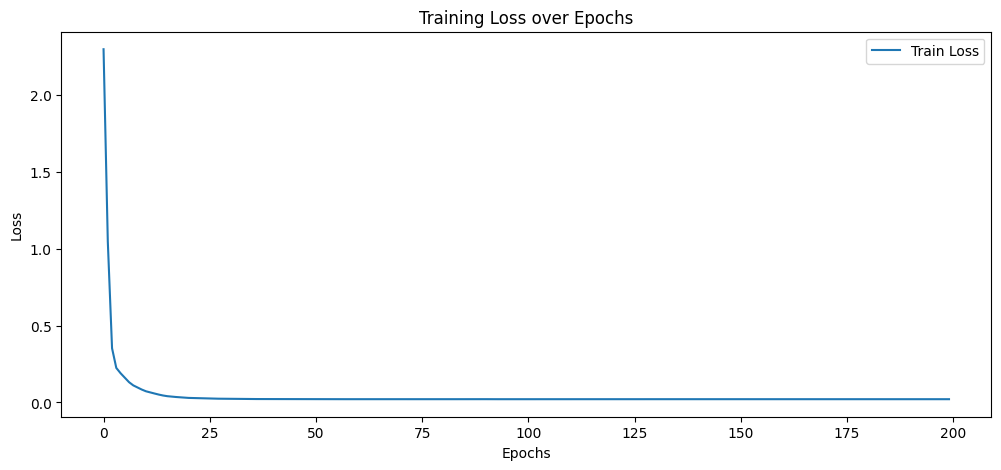

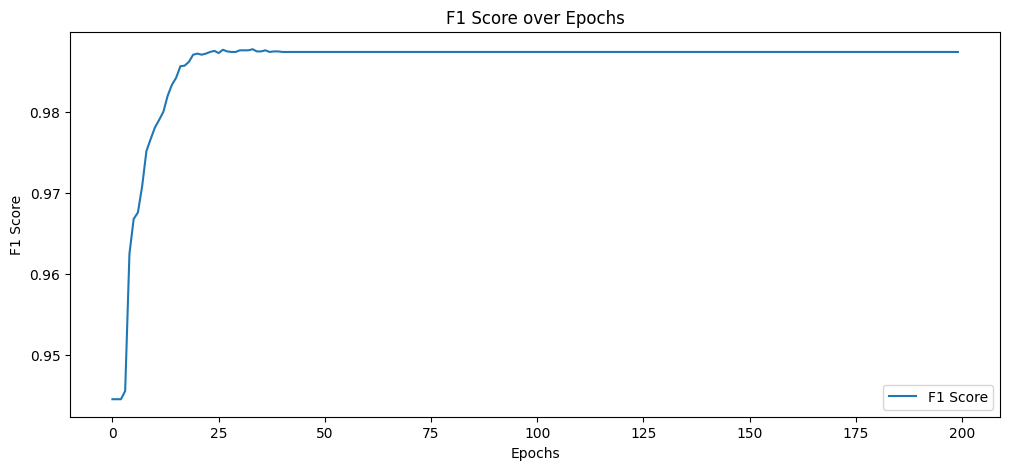

In [18]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import warnings
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

warnings.filterwarnings("ignore")

# 檢查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 加載數據
train_df = pd.read_csv('hw2_train.csv')

# 初始化 BERT Tokenizer 和 Model
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
bert_model = BertModel.from_pretrained("bert-large-uncased").to(device)

# 設定最大序列長度
MAX_LENGTH = 32

# 調整 BERT 編碼函數
def encode_texts(texts, tokenizer, bert_model, device, max_length=MAX_LENGTH):
    inputs = tokenizer(
        texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state  # Shape: (batch_size, max_length, hidden_dim)
    return embeddings, inputs["attention_mask"].sum(dim=1)

# 提取句子的 BERT 嵌入
utterances = train_df['utterances'].tolist()
embeddings, sequence_lengths = encode_texts(utterances, tokenizer, bert_model, device)

# 構建標籤映射字典
unique_labels = set(label for tags in train_df['IOB Slot tags'] for label in tags.split())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_index.items()}

# 將標籤轉換為數字格式並填充到 BERT 輸出的 max_length 長度
labels = train_df['IOB Slot tags'].apply(lambda x: [label_to_index[label] for label in x.split()])
labels_padded = pad_sequence(
    [torch.tensor(label + [label_to_index["O"]] * (MAX_LENGTH - len(label))) for label in labels], 
    batch_first=True
).to(device)

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels_padded, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

# 定義 Focal Loss 類
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - p_t) ** self.gamma) * ce_loss
        return focal_loss.mean()

# 使用最佳超參數來定義 GRU 模型
class SlotTaggingModelGRU(nn.Module):
    def __init__(self, bert_hidden_dim, hidden_dim=131, output_dim=None, dropout_prob=0.23450624849590243, num_layers=2):
        super(SlotTaggingModelGRU, self).__init__()
        self.gru = nn.GRU(
            bert_hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_prob
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        gru_out = self.layer_norm(gru_out)
        gru_out = self.dropout(gru_out)
        attn_weights = torch.softmax(self.attention(gru_out), dim=1)
        gru_out = gru_out * attn_weights
        output = self.fc(gru_out)
        return output

# 初始化模型、損失函數和優化器
bert_hidden_dim = embeddings.shape[2]
output_dim = len(label_to_index)

model = SlotTaggingModelGRU(
    bert_hidden_dim=bert_hidden_dim,
    hidden_dim=131,
    output_dim=output_dim,
    dropout_prob=0.23450624849590243,
    num_layers=2
).to(device)

criterion = FocalLoss(alpha=1, gamma=2)
optimizer = AdamW(model.parameters(), lr=0.0009950695432002095, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# 訓練函數
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x).view(-1, output_dim)
        batch_y = batch_y.view(-1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# 評估函數
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x).view(-1, output_dim)
            batch_y = batch_y.view(-1)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = batch_y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    correct = np.sum(np.array(all_preds) == np.array(all_labels))
    f1 = correct / len(all_labels)
    return total_loss / len(test_loader), f1

# 訓練和評估模型
num_epochs = 200  # 根據需要調整
train_losses, f1_scores = [], []

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, f1 = evaluate_model(model, test_loader, criterion, device)
    scheduler.step()
    
    train_losses.append(train_loss)
    f1_scores.append(f1)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test F1 Score: {f1:.4f}")

# 繪製 Loss 和 F1 Score 圖
plt.figure(figsize=(12, 5))
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(range(num_epochs), f1_scores, label="F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()
plt.show()


In [19]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from seqeval.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# 載入測試數據
test_df = pd.read_csv('hw2_test.csv')

# 定義生成提交文件的函數
def generate_submission_file(model, test_df, tokenizer, bert_model, idx_to_label, device, output_file="submission_GRU_Large300.csv"):
    model.eval()
    predictions = []

    with torch.no_grad():
        for idx, row in test_df.iterrows():
            utterance = row["utterances"]
            
            # 1. 使用 BERT 將句子轉換為嵌入
            inputs = tokenizer(utterance, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
            embeddings = bert_model(**inputs).last_hidden_state  # 取得 BERT 最後一層的輸出 (batch_size, seq_len, hidden_dim)
            
            # 2. 使用模型進行預測
            outputs = model(embeddings)  # 模型輸出應為 (batch_size, seq_len, output_dim)
            
            # 3. 確保 outputs 的維度符合預期
            if outputs.dim() == 2:  # 當輸出只有 (seq_len, output_dim) 時進行擴展
                outputs = outputs.unsqueeze(0)  # 增加 batch 維度

            # 4. 獲取每個位置的預測標籤
            pred_labels = torch.argmax(outputs, dim=2).squeeze().cpu().numpy()
            pred_labels = [idx_to_label[label] for label in pred_labels[:len(inputs['input_ids'][0])]]

            # 5. 將子詞標籤整合成單詞標籤，處理 "O" 標籤
            tokens = tokenizer.tokenize(utterance)
            final_labels = []
            token_idx = 0

            for label in pred_labels:
                if token_idx >= len(tokens):
                    break  # 防止 token_idx 超出 tokens 的長度
                
                # 對於子詞，給出 "O" 標籤
                if tokens[token_idx].startswith("##"):
                    token_idx += 1
                    continue
                
                # 添加主詞的標籤，並在子詞中持續使用 "O" 標籤
                final_labels.append(label if label != "O" else "O")
                token_idx += 1

            # 6. 加入預測結果
            predictions.append(final_labels)

    # 建立提交文件格式
    submission_df = pd.DataFrame({"ID": test_df["ID"], "IOB Slot tags": [" ".join(tags) for tags in predictions]})
    submission_df.to_csv(output_file, index=False)
    print(f"提交文件已生成：{output_file}")

# 評估模型性能的函數
def evaluate_model_seqeval(model, data_loader, tokenizer, bert_model, idx_to_label, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            # 檢查 batch 中是否有兩個元素（inputs 和 labels）
            if len(batch) == 2:
                inputs, labels = batch
            else:
                raise ValueError("Expected batch to contain inputs and labels, but got different structure.")

            labels = labels.to(device)
            
            # 使用 BERT 將句子轉換為嵌入
            inputs = tokenizer(
                inputs, padding="max_length", truncation=True, max_length=128, return_tensors="pt"
            ).to(device)
            embeddings = bert_model(**inputs).last_hidden_state  # 取得 BERT 最後一層的輸出

            # 使用模型進行預測
            outputs = model(embeddings)
            pred_labels = torch.argmax(outputs, dim=2).cpu().numpy()
            true_labels = labels.cpu().numpy()

            # 將預測和真實標籤轉換為 IOB2 格式
            batch_preds = []
            batch_labels = []

            for pred_seq, true_seq in zip(pred_labels, true_labels):
                preds = [idx_to_label[label] for label in pred_seq]
                trues = [idx_to_label[label] for label in true_seq]

                # 將標籤添加到 seqeval 格式
                batch_preds.append(preds)
                batch_labels.append(trues)

            all_preds.extend(batch_preds)
            all_labels.extend(batch_labels)

    # 使用 seqeval 計算 F1 分數
    f1 = f1_score(all_labels, all_preds)
    print(classification_report(all_labels, all_preds))
    print(f"Validation F1 Score: {f1:.4f}")
    return f1

# 構建標籤映射字典
unique_labels = set(label for tags in train_df['IOB Slot tags'] for label in tags.split())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_index.items()}

# 生成提交文件
generate_submission_file(model, test_df, tokenizer, bert_model, idx_to_label, device)

# 評估模型性能
# 確保在 validation 或測試集上進行評估
evaluate_model_seqeval(model, test_loader, tokenizer, bert_model, idx_to_label, device)


提交文件已生成：submission_GRU_Large300.csv


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

Using device: cuda
              precision    recall  f1-score   support

       _cast       0.00      0.00      0.00        18
       _char       0.00      0.00      0.00         1
    _country       0.00      0.00      0.00        23
   _director       0.00      0.00      0.00        32
      _genre       0.00      0.00      0.00        13
   _language       0.00      0.00      0.00        20
   _location       0.00      0.00      0.00         1
      _movie       0.00      0.00      0.00       217
_mpaa_rating       0.00      0.00      0.00        32
     _person       0.00      0.00      0.00        39
   _producer       0.00      0.00      0.00        38
    _subject       0.00      0.00      0.00        21

   micro avg       0.00      0.00      0.00       455
   macro avg       0.00      0.00      0.00       455
weighted avg       0.00      0.00      0.00       455

Epoch 1/200, Train Loss: 2.2733, Test F1 Score: 0.0000
              precision    recall  f1-score   support

    

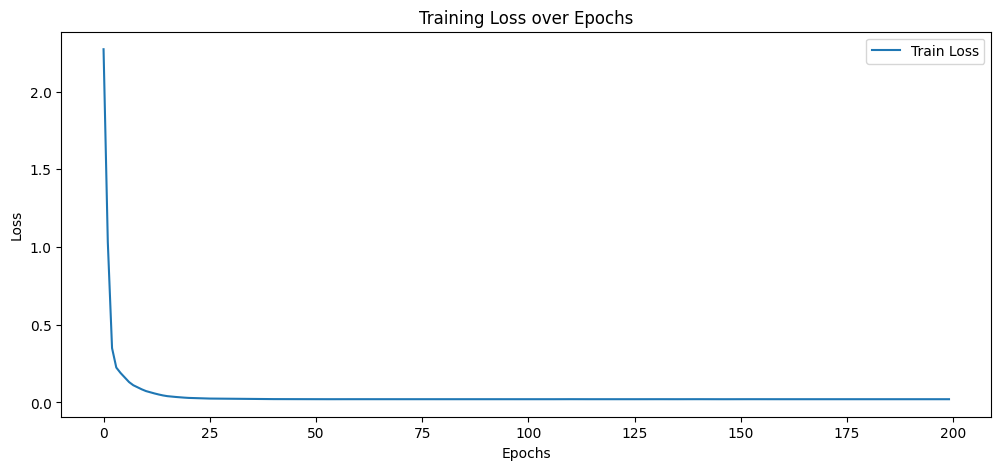

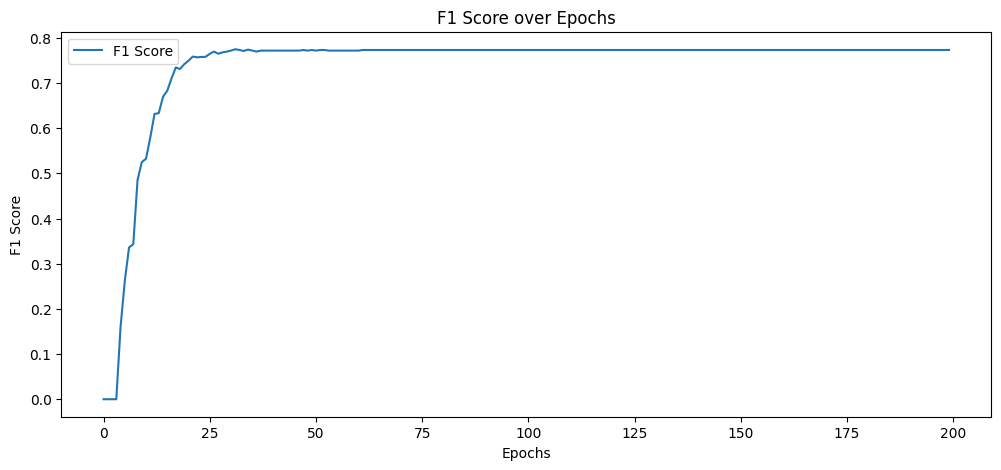

提交文件已生成：submission_GRU_Large300.csv


In [25]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import warnings
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from seqeval.metrics import f1_score, classification_report

warnings.filterwarnings("ignore")

# 檢查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 加載訓練數據
train_df = pd.read_csv('hw2_train.csv')

# 初始化 BERT Tokenizer 和 Model
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
bert_model = BertModel.from_pretrained("bert-large-uncased").to(device)

# 設定最大序列長度
MAX_LENGTH = 32

# 調整 BERT 編碼函數
def encode_texts(texts, tokenizer, bert_model, device, max_length=MAX_LENGTH):
    inputs = tokenizer(
        texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state  # Shape: (batch_size, max_length, hidden_dim)
    return embeddings, inputs["attention_mask"].sum(dim=1)

# 提取句子的 BERT 嵌入
utterances = train_df['utterances'].tolist()
embeddings, sequence_lengths = encode_texts(utterances, tokenizer, bert_model, device)

# 構建標籤映射字典
unique_labels = set(label for tags in train_df['IOB Slot tags'] for label in tags.split())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_index.items()}

# 將標籤轉換為數字格式並填充到 BERT 輸出的 max_length 長度
labels = train_df['IOB Slot tags'].apply(lambda x: [label_to_index[label] for label in x.split()])
labels_padded = nn.utils.rnn.pad_sequence(
    [torch.tensor(label + [label_to_index["O"]] * (MAX_LENGTH - len(label))) for label in labels], 
    batch_first=True
).to(device)

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels_padded, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

# 定義 Focal Loss 類
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - p_t) ** self.gamma) * ce_loss
        return focal_loss.mean()

# 定義 GRU 模型
class SlotTaggingModelGRU(nn.Module):
    def __init__(self, bert_hidden_dim, hidden_dim=131, output_dim=None, dropout_prob=0.23450624849590243, num_layers=2):
        super(SlotTaggingModelGRU, self).__init__()
        self.gru = nn.GRU(
            bert_hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_prob
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        gru_out = self.layer_norm(gru_out)
        gru_out = self.dropout(gru_out)
        attn_weights = torch.softmax(self.attention(gru_out), dim=1)
        gru_out = gru_out * attn_weights
        output = self.fc(gru_out)
        return output

# 初始化模型、損失函數和優化器
bert_hidden_dim = embeddings.shape[2]
output_dim = len(label_to_index)

model = SlotTaggingModelGRU(
    bert_hidden_dim=bert_hidden_dim,
    hidden_dim=131,
    output_dim=output_dim,
    dropout_prob=0.23450624849590243,
    num_layers=2
).to(device)

criterion = FocalLoss(alpha=1, gamma=2)
optimizer = AdamW(model.parameters(), lr=0.0009950695432002095, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# 訓練函數
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x).view(-1, output_dim)
        batch_y = batch_y.view(-1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# 使用 seqeval 的評估函數
def evaluate_model(model, test_loader, criterion, device, idx_to_label):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x).view(-1, output_dim)
            batch_y = batch_y.view(-1)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = batch_y.cpu().numpy()

            preds = preds.reshape(batch_x.size(0), -1)
            labels = labels.reshape(batch_x.size(0), -1)

            for pred, label in zip(preds, labels):
                pred_tags = [idx_to_label[idx] for idx in pred if idx in idx_to_label]
                true_tags = [idx_to_label[idx] for idx in label if idx in idx_to_label]
                all_preds.append(pred_tags)
                all_labels.append(true_tags)

    f1 = f1_score(all_labels, all_preds)
    print(classification_report(all_labels, all_preds))

    return total_loss / len(test_loader), f1

# 訓練和評估模型
num_epochs = 200  # 根據需要調整
train_losses, f1_scores = [], []

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, f1 = evaluate_model(model, test_loader, criterion, device, idx_to_label)
    scheduler.step()
    
    train_losses.append(train_loss)
    f1_scores.append(f1)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test F1 Score: {f1:.4f}")

# 繪製 Loss 和 F1 Score 圖
plt.figure(figsize=(12, 5))
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(range(num_epochs), f1_scores, label="F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()
plt.show()

# 生成提交文件
test_df = pd.read_csv('hw2_test.csv')

def generate_submission_file(model, test_df, tokenizer, bert_model, idx_to_label, device, output_file="submission_GRU_Large300.csv"):
    model.eval()
    predictions = []

    with torch.no_grad():
        for idx, row in test_df.iterrows():
            utterance = row["utterances"]
            inputs = tokenizer(utterance, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
            embeddings = bert_model(**inputs).last_hidden_state
            
            outputs = model(embeddings)
            
            if outputs.dim() == 2:
                outputs = outputs.unsqueeze(0)

            pred_labels = torch.argmax(outputs, dim=2).squeeze().cpu().numpy()
            pred_labels = [idx_to_label[label] for label in pred_labels[:len(inputs['input_ids'][0])]]

            tokens = tokenizer.tokenize(utterance)
            final_labels = []
            token_idx = 0

            for label in pred_labels:
                if token_idx >= len(tokens):
                    break
                if tokens[token_idx].startswith("##"):
                    token_idx += 1
                    continue
                final_labels.append(label if label != "O" else "O")
                token_idx += 1

            predictions.append(final_labels)

    submission_df = pd.DataFrame({"ID": test_df["ID"], "IOB Slot tags": [" ".join(tags) for tags in predictions]})
    submission_df.to_csv(output_file, index=False)
    print(f"提交文件已生成：{output_file}")

# 使用生成提交文件函數
generate_submission_file(model, test_df, tokenizer, bert_model, idx_to_label, device)
